In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lattice import Triangular_Lattice
from walker import Graphene_Walker

%load_ext autoreload
%matplotlib inline

## Visualize Moire Potential

<a list of 90 text.Text objects>

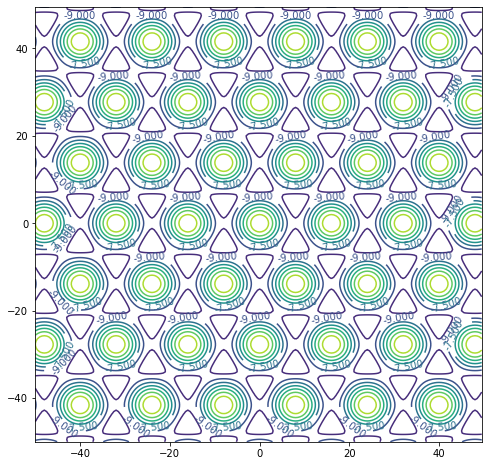

In [8]:
%autoreload 2
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

delta = 0.5
x = np.arange(-50, 50, delta)
y = np.arange(-50, 50, delta)
X, Y = np.meshgrid(x, y)
moire = Triangular_Lattice(16, 1) # 16nm lattice constant, 1eV energy amplitude
Z = moire.U(X, Y)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)

## Parameterize random walkers

In [9]:
%autoreload 2
from walker import Graphene_Walker
moire = Triangular_Lattice(16, 1) # 16nm lattice constant, 1meV energy amplitude
walkers = Graphene_Walker(0.246, 15) # 2.46 Angstrom lattice, 10 Kelvin
tracks = walkers.get_tracks(moire, nsteps=300, njumps=100000, nparticles=100)

<AxesSubplot:xlabel='x'>

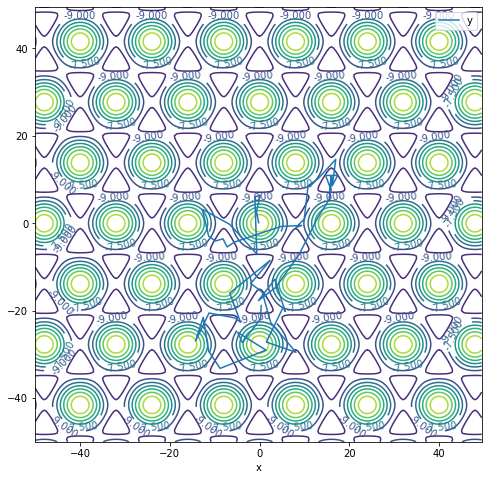

In [10]:
%autoreload 2
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

delta = 0.5
x = np.arange(-50, 50, delta)
y = np.arange(-50, 50, delta)
X, Y = np.meshgrid(x, y)
moire = Triangular_Lattice(16, 1) # 16nm lattice constant, 1eV energy amplitude
Z = moire.U(X, Y)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
tracks[tracks['particle'] == 0].plot(x = 'x', y='y', ax=ax)

# Wait Time Tail

In [55]:
%%time
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product

temps = [4, 6, 8, 10, 12, 14, 16]
lattice_constants = [4, 8, 12, 16]
barrier = 19.8

kws = {
    'njumps' : 1000000, 
    'nparticles' : 10, 
    'init' : 1000,
}

def get_waits(m_lattice, temperature, total_particles=1000, **kws):
    moire = Triangular_Lattice(m_lattice, barrier) # 16nm lattice constant, 1meV energy amplitude
    walkers = Graphene_Walker(0.246, temperature) # 2.46 Angstrom lattice, 10 Kelvin
    tracks = walkers.walk(**kws)
    waits = np.random.choice(walkers.get_waits(moire, tracks, **kws).flatten(), size=1000000)
    return waits
result = Parallel(n_jobs=-1, prefer='threads')(delayed(get_waits)(m_lattice, temperature, **kws) for m_lattice, temperature in tqdm(product(lattice_constants, temps)))
print('done')

28it [00:12,  2.21it/s]


done
CPU times: user 1min 24s, sys: 9.86 s, total: 1min 34s
Wall time: 29.6 s


Text(0, 0.5, 'PDF')

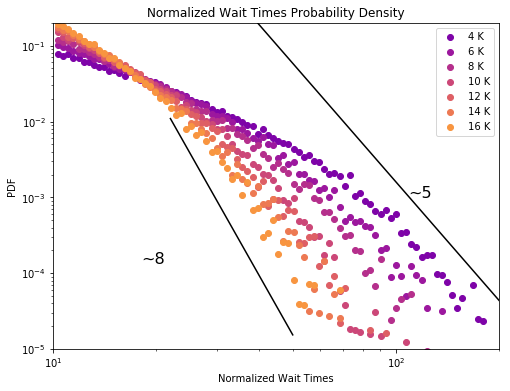

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
col = plt.cm.plasma(np.linspace(0.25, 0.75, len(temps)))
waits = np.array(result).reshape((len(lattice_constants), len(temps), 1000000))
for i, T in enumerate(temps):
    yy, xx = np.histogram(waits[3, i] / np.mean(waits[3, i]), np.logspace(1, np.log10(3e2), 100), density=True)
    xmax = np.max(xx)
    ax.scatter(xx[1:-1], yy[1:], color=col[i], label='{} K'.format(T))
ax.set_ylim(1e-5, 2e-1)
ax.set_xlim(10, 200)
ax.plot(xx[xx>(0.1*xmax)], 4e7*xx[xx>(0.1*xmax)]**(-5.2), color='k')
xx = np.linspace(22, 50, 100)
ax.plot(xx[xx>(0.01*xmax)], 6e8*xx[xx>(0.01*xmax)]**(-8), color='k')
ax.legend()
ax.annotate('~5', (200, 1e-4),
            xytext=(0.85, 0.5), textcoords='axes fraction',
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')
ax.annotate('~8', (200, 1e-4),
            xytext=(0.25, 0.3), textcoords='axes fraction',
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.title('Normalized Wait Times Probability Density')
plt.xlabel('Normalized Wait Times')
plt.ylabel('PDF')

## Distribution of Displacement

In [71]:
def plot_hist_dots(ax, x,y, xmin="", xmax="", title="", text="", log=False):


    dx1 = np.concatenate([np.diff(x),np.diff(y)])
    yy, xx = np.histogram(dx1, 50, density=True)
    
    xmax = np.max(xx[xx>0])
    xmin = np.min(xx[xx>0])

    ymin = np.min(yy[yy>0])
    ymax = np.max(yy[yy>0])
    
    xx = xx[:-1] + (xx[1] - xx[0])/2
    
    ax.scatter(xx, yy, c='gray', marker='o', s=40)
#     ax.plot(xx[xx>(0.1*xmax)], 0.05*xx[xx>(0.1*xmax)]**(-3), ls='-',color='coral')
    ax.plot(xx[xx>(0.2*xmax)], 0.05*xx[xx>(0.2*xmax)]**(-3), ls='-',color='coral')
    ax.text(0.9, 0.6,r'$\delta x^{-3.0}$', fontsize=16,
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes)
    ax.set_xlabel(r'Displacement $\delta x(t_{fr})$',fontsize=16)

    ax.margins(0.1)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(1e-1,10)
    ax.set_title(title,fontsize=14)
    if log:
        ax.set_yscale('log')
        ax.set_xscale('log')
    return ax

CPU times: user 8.77 s, sys: 1.76 s, total: 10.5 s
Wall time: 11.4 s


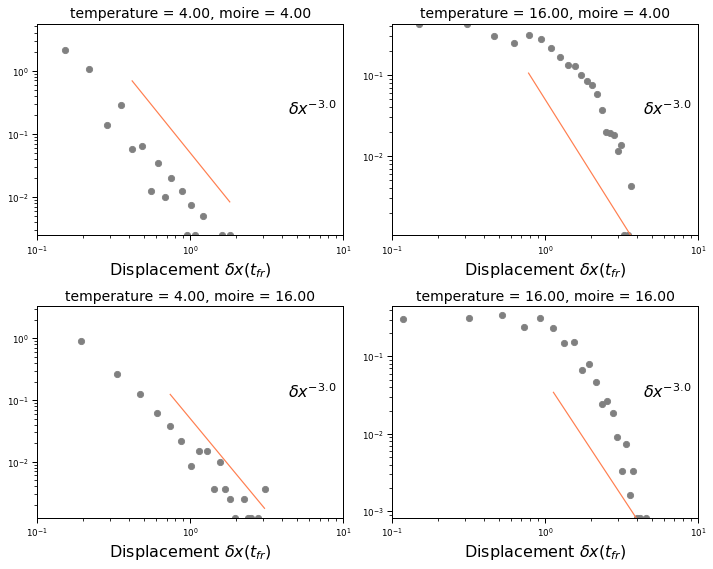

In [75]:
%%time
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product
import seaborn as sns

temperature = [4,16]
periodicity = [4,16]
barrier = 19.8

kws = {
    'njumps' : 1000000, 
    'nparticles' : 10, 
    'init' : 1000,
}
with sns.plotting_context("paper"):
    fig, axes = plt.subplots(2, 2, figsize=(10,8))  
    for i,period in enumerate(periodicity):
        for j,temp in enumerate(temperature):

            ax = axes.flatten()[2*i+j]
           ## generate tracks at that temperature
            moire = Triangular_Lattice(period, 2) # 16nm lattice constant, 1meV energy amplitude
            walkers = Graphene_Walker(0.246, temp) # 2.46 Angstrom lattice, 10 Kelvin
            tracks = walkers.get_tracks(moire, nsteps=300, njumps=1000000, nparticles=10, endT=1e5)
#             waits = np.random.choice(walkers.get_waits(moire, tracks, **kws).flatten(), size=1000000)
            ## gather x and y values
            x = []
            y = []
            for particle in list(set(tracks['particle'])):
                x.append(np.array(tracks[tracks['particle'] == particle]['x']))
                y.append(np.array(tracks[tracks['particle'] == particle]['y']))
            x = np.array(x)
            y = np.array(y)

            title='temperature = {:.2f}, moire = {:.2f}'.format(temp, period)
            ax = plot_hist_dots(ax, x,y,title=title,log=True)
            fig.tight_layout()
fig.savefig('./displacement_dist.png', dpi=300, bbox_inches='tight')

## Temperature Plots (figure 3)

In [2]:
%autoreload 2
from utils import *

2021-09-30 12:19:21.864763: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-30 12:19:21.864825: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
temperatures = [4, 6, 8, 10, 12, 14, 16]
periodicity = [4, 8, 12, 16]
nsteps = 300

period_temp_activations = []
period_temp_predictions = []
period_temp_values = []
period_num_fbm = []
period_num_brownian = []
period_num_ctrw = []
 

for period in periodicity:
    all_temp_activations = []
    all_temp_predictions = []
    all_temp_values = []
    num_fbm = []
    num_brownian = []
    num_ctrw = []
    for temp in temperatures:
        
        ## generate tracks at that temperature
        moire = Triangular_Lattice(period, 2) # 16nm lattice constant, 1meV energy amplitude
        walkers = Graphene_Walker(0.246, temp) # 2.46 Angstrom lattice, 10 Kelvin
        tracks = walkers.get_tracks(moire, nsteps=nsteps, njumps=100000, nparticles=400, endT=1e5)

        ## gather x and y values
        x = []
        y = []
        for particle in list(set(tracks['particle'])):
            x.append(np.array(tracks[tracks['particle'] == particle]['x']))
            y.append(np.array(tracks[tracks['particle'] == particle]['y']))
        x = np.array(x)
        y = np.array(y)

        ## calculate dx and y
        temp_x = x-np.mean(x)
        temp_dx = np.diff(temp_x)
        temp_dx = temp_dx/np.std(temp_dx)

        print(temp_dx)
        ## trim x and y to shape
        temp_dx = temp_dx[:,::int(temp_dx.shape[1] / nsteps)][:,:-1]

        temp_values, temp_predictions = classification_on_real(temp_dx, steps=nsteps)
        all_temp_activations.append(get_activations(temp_dx, steps=nsteps))

        num_fbm.append(sum([1 for idx, x in temp_predictions if x == 0]))
        num_brownian.append(sum([1 for idx, x in temp_predictions if x == 1]))
        num_ctrw.append(sum([1 for idx, x in temp_predictions if x == 2]))

        all_temp_predictions.append(temp_predictions)
        all_temp_values.append(temp_values)
    period_temp_activations.append(all_temp_activations)
    period_temp_predictions.append(all_temp_predictions)
    period_temp_values.append(all_temp_values)
    period_num_fbm.append(num_fbm)
    period_num_brownian.append(num_brownian)
    period_num_ctrw.append(num_ctrw)
    
all_temp_activations = np.array(all_temp_activations)

[[-1.10896381e+00 -8.66868306e-16  2.95723684e+00 ...  5.77912204e-16
   3.69654604e-01  7.39309209e-01]
 [ 6.28412828e+00  1.10896381e+00  1.10896381e+00 ... -3.69654604e-01
   2.31164882e-15  0.00000000e+00]
 [-2.58758223e+00  3.69654604e-01  0.00000000e+00 ...  1.10896381e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-5.91447367e+00 -1.10896381e+00  3.69654604e-01 ...  2.58758223e+00
   0.00000000e+00 -3.69654604e-01]
 [-3.32689144e+00 -3.69654604e-01 -1.10896381e+00 ... -1.10896381e+00
  -7.39309209e-01  0.00000000e+00]
 [ 2.21792763e+00  7.39309209e-01  3.69654604e-01 ...  3.69654604e-01
  -1.47861842e+00  0.00000000e+00]]


2021-09-30 12:22:16.286252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-30 12:22:16.286312: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-30 12:22:16.286362: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nuke): /proc/driver/nvidia/version does not exist
2021-09-30 12:22:17.353972: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[[-2.55113157e+00  3.40150876e-01 -1.02045263e+00 ...  0.00000000e+00
   1.36060350e+00 -5.10226313e-01]
 [-1.70075438e-01  2.65893269e-16 -8.50377189e-01 ... -5.10226313e-01
  -5.10226313e-01 -3.40150876e-01]
 [-5.10226313e-01 -1.70075438e+00 -5.10226313e-01 ... -3.40150876e-01
   0.00000000e+00 -1.02045263e+00]
 ...
 [ 1.87082982e+00  1.02045263e+00  6.80301751e-01 ... -5.10226313e-01
   1.19052806e+00  3.40150876e-01]
 [-1.70075438e+00 -1.36060350e+00  5.44241401e+00 ...  6.80301751e-01
   8.50377189e-01 -3.40150876e-01]
 [-2.55113157e+00  2.38105613e+00  0.00000000e+00 ... -5.10226313e-01
   1.02045263e+00  3.40150876e-01]]
[[ 1.37718779e+00 -4.59062597e-01 -6.88593895e-01 ... -2.29531298e-01
  -3.44296948e-01 -1.14765649e+00]
 [ 3.44296948e-01 -1.37718779e+00  9.18125194e-01 ...  6.88593895e-01
   3.44296948e-01  5.73828246e-01]
 [ 1.37718779e+00 -6.88593895e-01 -4.59062597e-01 ...  9.18125194e-01
  -3.44296948e-01  3.44296948e-01]
 ...
 [-1.14765649e+00 -6.88593895e-01  4.5906259

[[-2.19870807e-15 -1.12510178e+00 -1.35012214e+00 ... -6.75061068e-01
   1.01259160e+00 -1.01259160e+00]
 [ 1.23761196e+00 -6.75061068e-01  2.81275445e+00 ...  0.00000000e+00
  -3.37530534e-01  1.01259160e+00]
 [-7.87571246e-01 -2.25020356e-01 -7.87571246e-01 ... -1.40717316e-15
   4.50040712e-01  1.68765267e+00]
 ...
 [-1.12510178e-01  1.68765267e+00 -1.35012214e+00 ... -6.75061068e-01
   1.01259160e+00 -4.50040712e-01]
 [-2.36271374e+00  2.25020356e-01 -1.23761196e+00 ...  1.35012214e+00
  -1.12510178e-01  0.00000000e+00]
 [ 4.72542747e+00  3.37530534e-01 -2.36271374e+00 ...  1.01259160e+00
  -7.87571246e-01  1.80016285e+00]]
[[ 0.26791423 -0.53582847  1.51818065 ... -0.17860949 -0.08930474
  -0.17860949]
 [-0.53582847  2.32192335  0.26791423 ...  0.98235219 -0.53582847
  -0.53582847]
 [ 0.26791423 -0.62513321  0.26791423 ...  0.53582847 -1.6074854
   0.26791423]
 ...
 [-1.87539963 -0.26791423 -0.89304744 ...  0.71443796  0.62513321
  -0.08930474]
 [-0.08930474  1.96470438  1.5181806

Text(0.5, 1.0, 'Temperature vs Proportion of Class')

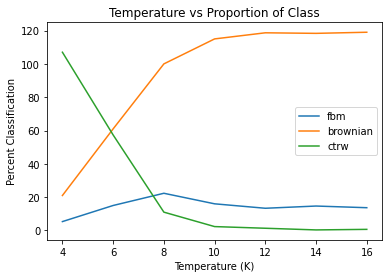

In [7]:
x = temperatures
plt.plot(x, np.array(period_num_fbm[0]) / 3, c="tab:blue",label="fbm")
plt.plot(x, np.array(period_num_brownian[0]) / 3, c="tab:orange", label="brownian")
plt.plot(x, np.array(period_num_ctrw[0]) / 3, c="tab:green",label="ctrw")
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Percent Classification")
plt.title("Temperature vs Proportion of Class")

## UMap

In [8]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

def manifold(dx, predictions, s=30, ax=None, markers = ["o",">","s"], color="tab:blue", fbm_coeffs=None, ctrw_alphas=None, embedding_name="umap"):
    if embedding_name == "tsne":
        embedded_dx = TSNE(init="pca", random_state=12345).fit_transform(dx)
    elif embedding_name == 'umap':
        dx_scaled = StandardScaler().fit_transform(dx)
        embedded_dx = UMAP(random_state=12345).fit_transform(dx_scaled)
    else:
        raise NotImplementedError
    
    fbm_points = np.array([x for idx, x in enumerate(embedded_dx) if predictions[idx][1] == 0])
    ctrw_points = np.array([x for idx, x in enumerate(embedded_dx) if predictions[idx][1] == 2])
    brownian_points = np.array([x for idx, x in enumerate(embedded_dx) if predictions[idx][1] == 1])

    fbm = None
    ctrw = None
    brownian = None
    plt_list = []
    plt_names = []
    if ax is None:
        ax = plt.axes()
        ax.figure.set_size_inches(12,8)
    if fbm_points.size != 0:
        if fbm_coeffs is not None:
            cmap = sns.cubehelix_palette(as_cmap=True)
            fbm = ax.scatter(fbm_points[:,0], fbm_points[:,1], s=s, 
                             c=fbm_coeffs*2,marker=markers[0], edgecolors='black',cmap=cmap)
        else:
            fbm = ax.scatter(fbm_points[:,0], fbm_points[:,1], s=s, c=color,marker=markers[0], edgecolors='black')
        plt_list.append(fbm)
        plt_names.append("fbm")
    if ctrw_points.size != 0:
        if ctrw_alphas is not None:
            cmap = sns.cubehelix_palette(as_cmap=True, rot=-0.4)
            ctrw = ax.scatter(ctrw_points[:,0], ctrw_points[:,1], s=s, 
                              c=ctrw_alphas, marker=markers[1], edgecolors='black', cmap=cmap)
        else:
            ctrw = ax.scatter(ctrw_points[:,0], ctrw_points[:,1], s=s, c=color, marker=markers[1], edgecolors='black')
        plt_list.append(ctrw)
        plt_names.append("ctrw")
    if brownian_points.size != 0:
        brownian = ax.scatter(brownian_points[:,0], brownian_points[:,1], s=s, c=color, marker=markers[2],edgecolors='black')
        plt_list.append(brownian)
        plt_names.append("brownian")

    plt.legend(plt_list, plt_names)
    return ctrw, ax

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

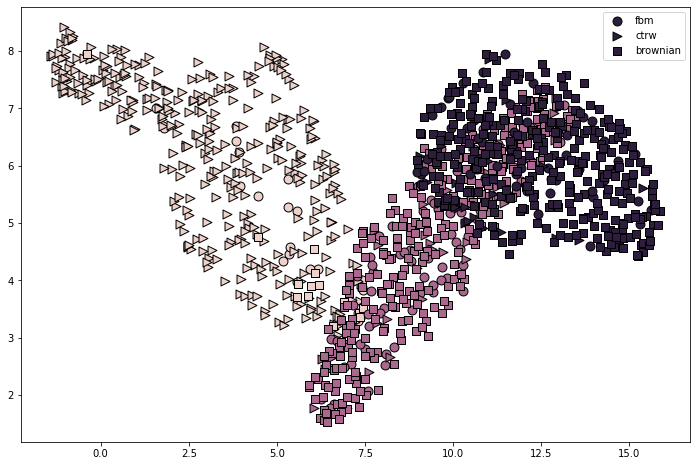

In [25]:
import seaborn as sns
marker_size = 80
colors = sns.cubehelix_palette(7)
ctrw1, ax = manifold(all_temp_activations[0].squeeze(), all_temp_predictions[0], s = marker_size, color=colors[0])
ctrw2, ax = manifold(all_temp_activations[3].squeeze(), all_temp_predictions[4], s = marker_size, ax=ax, color=colors[3])
ctrw3, ax = manifold(all_temp_activations[6].squeeze(), all_temp_predictions[6], s = marker_size, ax=ax, color=colors[6])